Model building

In [60]:
import torch.nn as nn
import torch.optim as optim

class Ivan_NN(nn.Module):
    def __init__(self, input_dim,):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(),
            nn.Linear(256,128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.LeakyReLU(),
            nn.Linear(64,1)
        )
    
    def forward(self, x):
        return self.layers(x)

print(Ivan_NN(28))

Ivan_NN(
  (layers): Sequential(
    (0): Linear(in_features=28, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=512, out_features=256, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [61]:
import torch
import pandas as pd
from torch.utils.data import Dataset

class TabularDataset(Dataset):
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [69]:
import torch
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, device=None):
    # Use GPU if available
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies= []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0


        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.squeeze().to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()# * inputs.size(0)

            # Optional: accuracy for classification
            if outputs.ndim == 1 or outputs.shape[1] == 1:  # binary
                preds = torch.round(torch.sigmoid(outputs))
            else:  # multiclass
                preds = torch.argmax(outputs, dim=1)

            correct += (preds == targets).sum().item()
            total += targets.size(0)



        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.squeeze().to(device)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item() # * inputs.size(0)

                if outputs.ndim == 1 or outputs.shape[1] == 1:
                    preds = torch.round(torch.sigmoid(outputs))
                else:
                    preds = torch.argmax(outputs, dim=1)

                val_correct += (preds == targets).sum().item()
                val_total += targets.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.6f} Acc: {train_acc:.6f} | "
              f"Val Loss: {val_loss:.6f} Acc: {val_acc:.6f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Acc', marker='o')
    plt.plot(val_accuracies, label='Validation Acc', marker='x')
    plt.title("Training vs. Validation Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [63]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader

def run_stratified_k_fold(X, y, epochs=10, batch_size = 64):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    foldData = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y),start=1):
        print(f"\n--- Fold {fold}/{5} ---")

        # Prepare train and validation data
        train_X, train_Y = X.iloc[train_idx], y.iloc[train_idx]
        val_X, val_Y = X.iloc[val_idx], y.iloc[val_idx]

        train_dataset = TabularDataset(train_X, train_Y)
        val_dataset = TabularDataset(val_X, val_Y)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        nInputs = len(X.columns)
        model = Ivan_NN(nInputs)
        posWeight = torch.tensor(8, dtype=torch.float32).to("cpu")
        criterion = nn.BCEWithLogitsLoss(pos_weight=posWeight)
        optimizer = optim.Adagrad(model.parameters() ,lr=0.0005, weight_decay=1e-3)

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies= []

        for epoch in range(epochs):
            print(f"   Epoch {epoch+1}/{epochs}")
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            # first_batch = True
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.squeeze().to(device)

                # Forward pass
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()# * inputs.size(0)

                # Optional: accuracy for classification
                # if outputs.ndim == 1 or outputs.shape[1] == 1:  # binary
                preds = torch.round(torch.sigmoid(outputs))
                # else:  # multiclass
                    # preds = torch.argmax(outputs, dim=1)

                correct += (preds == targets).sum().item()
                total += targets.numel()

                # if first_batch:
                #     for a, b in zip(targets,preds):
                #         print(a.item(), b.item())
                #     print("Correct:",correct)
                #     first_batch = False


            train_loss = running_loss / total
            train_acc = correct / total

            # Validation
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.squeeze().to(device)
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() # * inputs.size(0)

                    # if outputs.ndim == 1 or outputs.shape[1] == 1:
                    preds = torch.round(torch.sigmoid(outputs))
                    # else:
                        # preds = torch.argmax(outputs, dim=1)

                    val_correct += (preds == targets).sum().item()
                    val_total += targets.numel()

            val_loss /= val_total
            val_acc = val_correct / val_total

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

        foldData.append((train_losses,val_losses, train_accuracies,val_accuracies))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    colors = ["red","orange","blue","yellow","black"]
    for fold, (trainLoss,valLoss,trainAcc,valAcc) in enumerate(foldData,start=1):

        # plt.figure(figsize=(8, 5))
        ax1.plot(trainLoss[1:], label=f'Fold {fold} Train Loss', marker='o', color=colors[fold-1])
        ax1.plot(valLoss[1:], label=f'Fold {fold} Validation Loss', marker='x', color=colors[fold-1])
        ax2.plot(trainAcc[1:], label=f'Fold {fold} Train Acc', marker='o', color=colors[fold-1])
        ax2.plot(valAcc[1:], label=f'Fold {fold} Validation Acc', marker='x', color=colors[fold-1])


    ax1.set_title("Training vs. Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)
    # ax1.tight_layout()
    ax2.set_title("Training vs. Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()


    print("\n✅ Stratified K-Fold complete.")

Read CSV, split into X and Y

In [64]:
import pandas as pd

raw_dataset = pd.read_csv("./data/processed_data_smote.csv") #data has X and Y
display(raw_dataset)
X = raw_dataset.drop(columns=["DR"])
Y = pd.DataFrame(raw_dataset["DR"])

,name,age,image1,DR1,CSME1,HBPRP1,image2,DR2,CSME2,HBPRP2,...,Community_chonggu,Community_huaxin,Community_jinze,Community_liantang,Community_xianghuaqiao,Community_xujin,Community_yingpu,Community_zhaoxian,Community_zhujiajiao,DR
0,-1.679138,-0.031471,-0.030708,-0.622648,0.207493,0.263433,-0.034744,-0.620471,0.184818,0.263098,...,3.490498,-0.370248,-0.294404,-0.368753,-0.286492,-0.297334,-0.328403,-0.351875,-0.342822,0
1,-1.678583,0.107058,-0.030708,-0.622648,0.207493,0.263433,-0.034744,-0.620471,0.184818,0.263098,...,3.490498,-0.370248,-0.294404,-0.368753,-0.286492,-0.297334,-0.328403,-0.351875,-0.342822,0
2,-1.678028,2.877641,-0.030708,-0.622648,0.207493,0.263433,-0.034744,-0.620471,0.184818,0.263098,...,3.490498,-0.370248,-0.294404,-0.368753,-0.286492,-0.297334,-0.328403,-0.351875,-0.342822,0
3,-1.677473,-1.416763,-0.030708,-0.622648,0.207493,0.263433,-0.034744,-0.620471,0.184818,0.263098,...,3.490498,-0.370248,-0.294404,-0.368753,-0.286492,-0.297334,-0.328403,-0.351875,-0.342822,0
4,-1.676918,3.431757,-0.030708,-0.622648,0.207493,0.263433,-0.034744,-0.620471,0.184818,0.263098,...,3.490498,-0.370248,-0.294404,-0.368753,-0.286492,-0.297334,-0.328403,-0.351875,-0.342822,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8182,0.422903,0.784020,-0.030708,1.426436,0.207493,0.263433,-0.034744,1.535686,0.184818,0.263098,...,-0.286492,-0.370248,3.396692,-0.368753,-0.286492,-0.297334,-0.328403,-0.351875,-0.342822,1
8183,-1.346273,-0.154517,-0.030708,0.323071,0.207493,0.263433,-0.034744,1.535686,0.184818,0.263098,...,-0.286492,-0.370248,-0.294404,-0.368753,-0.286492,-0.297334,-0.328403,2.841918,-0.342822,1
8184,-0.102295,1.007537,-0.030708,1.772949,0.207493,0.263433,-0.034744,1.805175,0.184818,0.263098,...,-0.286492,-0.370248,-0.294404,2.711841,-0.286492,-0.297334,-0.328403,-0.351875,-0.342822,1
8185,0.389659,1.436243,-0.030708,1.506798,0.207493,0.263433,-0.034744,1.535686,0.184818,0.263098,...,-0.286492,-0.370248,3.396692,-0.368753,-0.286492,-0.297334,-0.328403,-0.351875,-0.342822,1


split data into [ training, validating, testing ]

In [65]:
from sklearn.model_selection import train_test_split

folds_X, test_X, folds_Y, test_Y = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)
print(type(folds_X),type(test_X),type(folds_Y),type(test_Y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


Dataset and dataloader

In [66]:
# import torch
# from torch.utils.data import Dataset, DataLoader


    
# batch_size = 64
# folds = 5

# train_dataset = TabularDataset(folds_X, folds_Y)
# test_dataset = TabularDataset(test_X, test_Y)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


--- Fold 1/5 ---
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10

--- Fold 2/5 ---
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10

--- Fold 3/5 ---
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10

--- Fold 4/5 ---
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10

--- Fold 5/5 ---
   Epoch 1/10
   Epoch 2/10
   Epoch 3/10
   Epoch 4/10
   Epoch 5/10
   Epoch 6/10
   Epoch 7/10
   Epoch 8/10
   Epoch 9/10
   Epoch 10/10


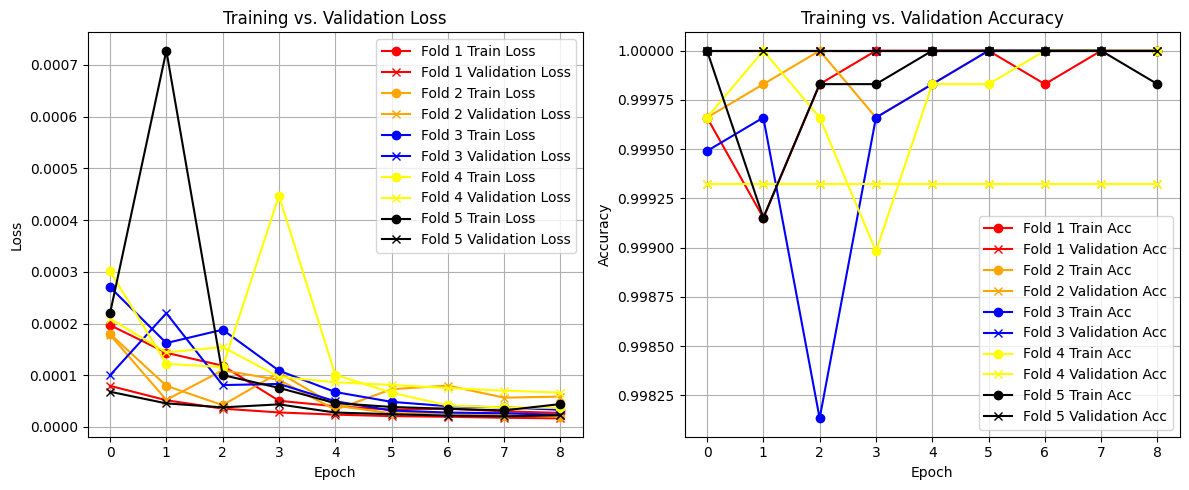


✅ Stratified K-Fold complete.


In [67]:
import torch.nn as nn
import torch.optim as optim
# nInputs = len(X.columns)
# model = Ivan_NN(nInputs)
# posWeight = torch.tensor(8, dtype=torch.float32).to("cpu")
# criterion = nn.BCEWithLogitsLoss(pos_weight=posWeight)
# optimiser = optim.Adagrad(model.parameters() ,lr=0.0005, weight_decay=1e-3)
epochs = 10
run_stratified_k_fold(folds_X,folds_Y,epochs)

Epoch [1/10] Train Loss: 0.006832 Acc: 0.874050 | Val Loss: 0.000284 Acc: 0.997558
Epoch [2/10] Train Loss: 0.000223 Acc: 0.998643 | Val Loss: 0.000281 Acc: 0.997558
Epoch [3/10] Train Loss: 0.000155 Acc: 0.999864 | Val Loss: 0.000259 Acc: 0.997558
Epoch [4/10] Train Loss: 0.000118 Acc: 0.999864 | Val Loss: 0.000173 Acc: 0.998779
Epoch [5/10] Train Loss: 0.000089 Acc: 0.999864 | Val Loss: 0.000089 Acc: 0.998779
Epoch [6/10] Train Loss: 0.000040 Acc: 1.000000 | Val Loss: 0.000029 Acc: 1.000000
Epoch [7/10] Train Loss: 0.000034 Acc: 1.000000 | Val Loss: 0.000132 Acc: 0.998779
Epoch [8/10] Train Loss: 0.000046 Acc: 0.999864 | Val Loss: 0.000247 Acc: 0.998779
Epoch [9/10] Train Loss: 0.000025 Acc: 1.000000 | Val Loss: 0.000211 Acc: 0.998779
Epoch [10/10] Train Loss: 0.000025 Acc: 1.000000 | Val Loss: 0.000190 Acc: 0.998779


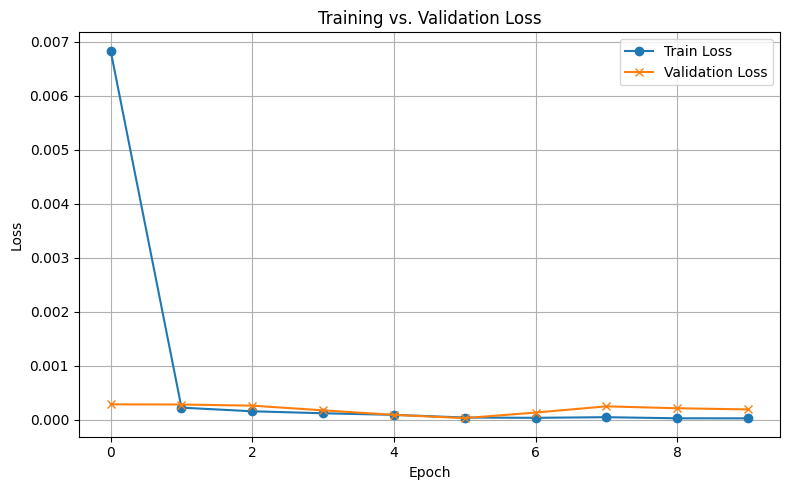

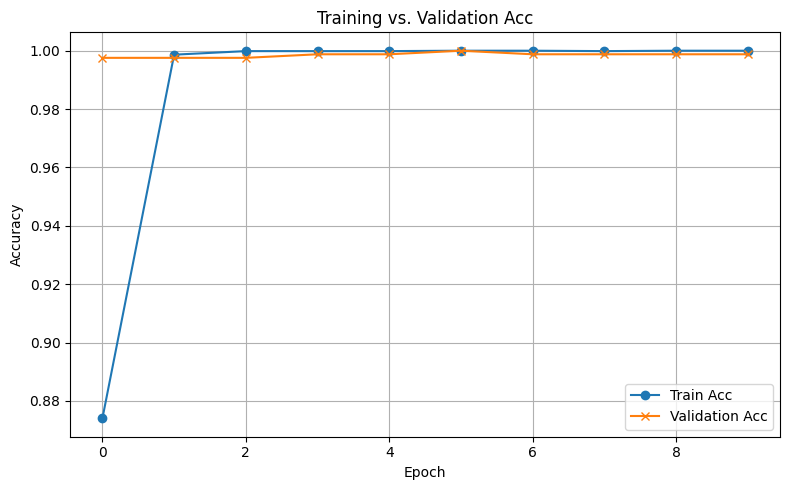

In [70]:
nInputs = len(X.columns)
batchSize = 64
model = Ivan_NN(nInputs)
posWeight = torch.tensor(8, dtype=torch.float32).to("cpu")
criterion = nn.BCEWithLogitsLoss(pos_weight=posWeight)
optimiser = optim.Adagrad(model.parameters() ,lr=0.0005, weight_decay=1e-3)

train_dataset = TabularDataset(folds_X, folds_Y)
test_dataset = TabularDataset(test_X, test_Y)

train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

train_model(model, train_loader, test_loader, criterion, optimiser, 10)